In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

nx = 9
ny = 6

def calibrate_camera(images, nx, ny):
    objpoints = []
    imgpoints = []
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    for image in images:
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    img = cv2.imread(images[0])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

images = glob.glob('camera_cal/calibration*.jpg')

ret, mtx, dist, rvecs, tvecs = calibrate_camera(images, nx, ny)


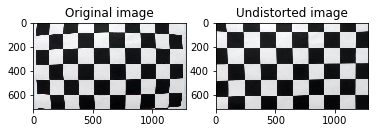

In [4]:
def undistort_image(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

image = cv2.imread(images[0])
image_undistorted = undistort_image(image, mtx, dist)
ax1 = plt.subplot(1,2,1)
plt.imshow(image)
ax2 = plt.subplot(1,2,2)
plt.imshow(image_undistorted)
ax1.set_title('Original image')
ax2.set_title('Undistorted image')
plt.show()

In [5]:
test_images = glob.glob('test_images/*.jpg')

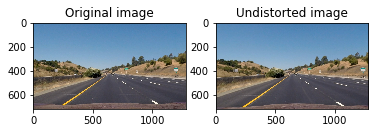

In [6]:
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_undistorted = undistort_image(image, mtx, dist)
ax1 = plt.subplot(1,2,1)
plt.imshow(image)
ax2 = plt.subplot(1,2,2)
plt.imshow(image_undistorted)
ax1.set_title('Original image')
ax2.set_title('Undistorted image')
plt.show()

## Gradient Thresholding

In [7]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_img = hls_img[:,:,2]
    if orient == 'x':
        sobel = cv2.Sobel(s_img, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(s_img, cv2.CV_64F, 0, 1)
    abs_sobelx = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

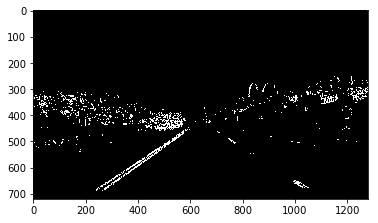

In [8]:
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=255)
plt.imshow(grad_binary, cmap='gray')
plt.show()

### S Heatmap

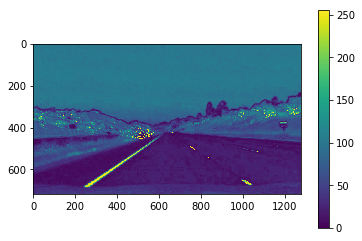

In [9]:
hls_img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
S = hls_img[:,:,2]
heat = plt.imshow(S)
plt.colorbar(heat)
plt.show()

### H Heatmap

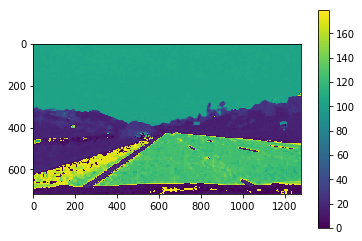

In [10]:
H = hls_img[:,:,0]
heat = plt.imshow(H)
plt.colorbar(heat)
plt.show()

### L Heatmap

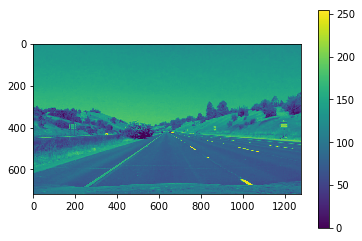

In [11]:
hls_img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
L = hls_img[:,:,1]
heat = plt.imshow(L)
plt.colorbar(heat)
plt.show()

## Color Thresholding

In [12]:
def s_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls_img[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary_output

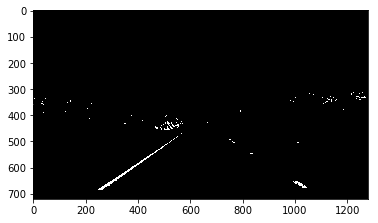

In [13]:
hls_binary = s_select(image, thresh=(200,255))
plt.imshow(hls_binary, cmap='gray')
plt.show()

## Combined thresholding

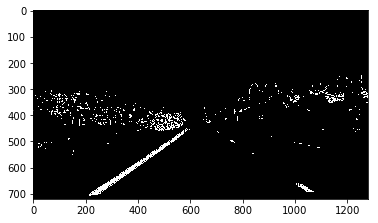

In [14]:
s_binary = s_select(image_undistorted, thresh=(200,255))
sx_binary = abs_sobel_thresh(image_undistorted, orient='x', thresh_min=20, thresh_max=100)
combined_binary = np.zeros_like(sx_binary)
combined_binary[(s_binary == 1) | (sx_binary == 1)] = 1
plt.imshow(combined_binary, cmap='gray')
plt.show()

## Perspective Transformation

In [15]:
original_lane = np.asarray([[240, 686], [1060, 686], [738, 480], [545 ,480]], np.float32)
transformed_lane = np.asarray([[300, 700], [1000, 700], [1000 , 300], [300, 300]], np.float32)
def transform_perspective(img):
    undistorted_image = undistort_image(img, mtx, dist)
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(original_lane, transformed_lane)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

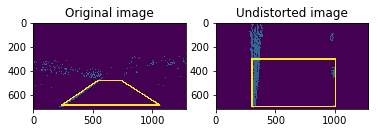

In [16]:
output = transform_perspective(combined_binary)
ax1 = plt.subplot(1,2,1)
cv2.polylines(combined_binary,[np.asarray([original_lane], np.int32).reshape((-1,1,2))],True,3, 10)
plt.imshow(combined_binary)
ax2 = plt.subplot(1,2,2)
cv2.polylines(output,[np.asarray([transformed_lane], np.int32).reshape((-1,1,2))],True,3, 10)
plt.imshow(output)
ax1.set_title('Original image')
ax2.set_title('Undistorted image')
plt.show()

# Image Processing Pipeline

In [17]:
def process_image(img, mtx, dist):
    undistorted_image = undistort_image(img, mtx, dist)
    s_binary = s_select(undistorted_image, thresh=(200,255))
    sx_binary = abs_sobel_thresh(undistorted_image, orient='x', thresh_min=20, thresh_max=100)
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(s_binary == 1) | (sx_binary == 1)] = 1
    transformed_image = transform_perspective(combined_binary)
    histogram = np.sum(transformed_image[int(transformed_image.shape[0]/2):,:], axis=0)
    return transformed_image

# Lane Lines

In [18]:
from collections import deque
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen=30)
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        self.recent_fits = deque(maxlen=30)
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

### Fitting polynomial on lane line

In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def fit_poly(binary_warped, image, left_line, right_line, plot=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    if (left_line.current_fit == None):
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        left_line.allx = leftx
        left_line.ally = lefty
        right_line.allx = rightx
        right_line.ally = righty

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        ploty = np.linspace(0, 719, num=720)
   
        # Now our radius of curvature is in meters
    #     print(left_curverad, 'm', right_curverad, 'm')
        # Example values: 632.1 m    626.2 m
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    else:
        left_fit = np.mean(np.asarray(left_line.recent_fits), axis=0)
        right_fit = np.mean(np.asarray(right_line.recent_fits), axis=0)
        # print(left_line.current_fit)
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    y_eval = np.max(ploty)
    
    left_line.recent_fits.append(left_fit)
    right_line.recent_fits.append(right_fit)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    left_line.current_fit = left_fit
    right_line.current_fit = right_fit
    left_line.radius_of_curvature = left_curverad
    right_line.radius_of_curvature = right_curverad
        
    left_line.recent_xfitted.append(left_fitx)
    right_line.recent_xfitted.append(right_fitx)
    
    left_line.bestx = np.mean(np.asarray(left_line.recent_xfitted), axis=0)
    right_line.bestx = np.mean(np.asarray(right_line.recent_xfitted), axis=0)

#     print(len(left_line.recent_xfitted))
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if plot:
        plt.figure()
        plt.imshow(out_img)
        plt.plot(left_line.bestx , ploty, color='yellow')
        plt.plot(right_line.bestx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    Minv = cv2.getPerspectiveTransform(transformed_lane, original_lane)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.bestx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
#     print(left_curverad, 'm', right_curverad, 'm')
    curvature = (left_curverad + right_curverad) / 2
    cv2.putText(result, "Curvature: {0:.2f}m".format(curvature), (30,60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), thickness=10)
    
    bottom_leftx = left_fitx[-1]
    bottom_rightx = right_fitx[-1]
    
    lane_center = (bottom_leftx + bottom_rightx) / 2
    
    car_center = 1280 / 2
    
    difference = lane_center - car_center
    
    difference_meters = difference * xm_per_pix
    
    if difference < 0:
        cv2.putText(result, "{0:.2f}m right of center".format(difference_meters), (30,110), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), thickness=10)
    else:
        cv2.putText(result, "{0:.2f}m left of center".format(difference_meters), (30,110), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), thickness=10)

    if plot:
        plt.figure()
        plt.imshow(result)
        plt.show()
    return result


In [20]:
def pipeline(image, plot=False):
    binary_warped = process_image(image, mtx, dist)
    result = fit_poly(binary_warped, image, left_line, right_line, plot)
    return result

In [21]:
%matplotlib qt5
left_line = Line()
right_line = Line()
pipeline(image, plot=True)

array([[[174, 191, 209],
        [133, 154, 175],
        [118, 144, 171],
        ..., 
        [ 32,  72,  98],
        [  6,  41,  61],
        [ 12,  45,  62]],

       [[131, 152, 173],
        [117, 141, 165],
        [100, 127, 157],
        ..., 
        [ 75, 119, 148],
        [ 47,  85, 108],
        [  2,  37,  57]],

       [[116, 143, 170],
        [101, 130, 160],
        [ 91, 124, 159],
        ..., 
        [ 82, 128, 162],
        [ 76, 120, 149],
        [ 33,  75, 100]],

       ..., 
       [[128, 117, 115],
        [100,  89,  87],
        [ 95,  81,  80],
        ..., 
        [ 85,  70,  67],
        [101,  85,  85],
        [133, 117, 117]],

       [[147, 135, 135],
        [121, 110, 108],
        [102,  91,  89],
        ..., 
        [ 91,  76,  73],
        [125, 109, 109],
        [149, 135, 134]],

       [[189, 177, 177],
        [144, 132, 132],
        [129, 118, 116],
        ..., 
        [127, 112, 109],
        [146, 132, 131],
        [191, 177,

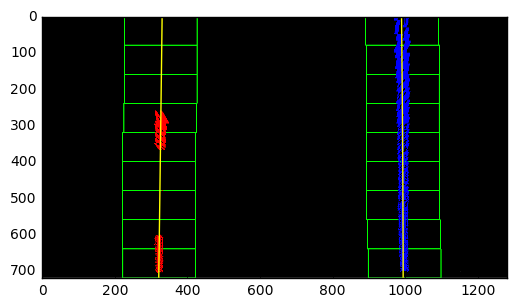

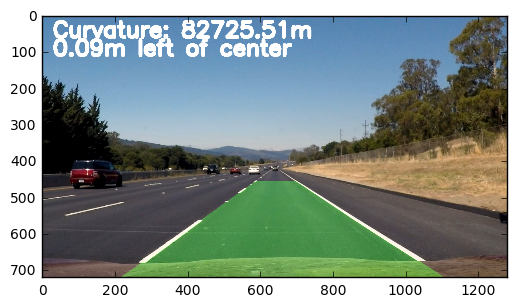

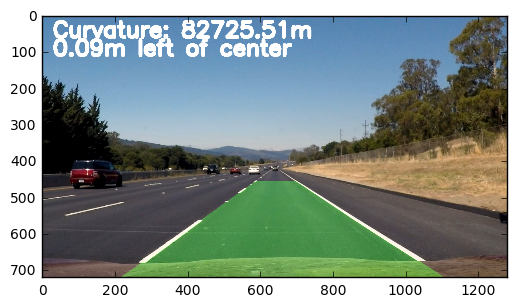

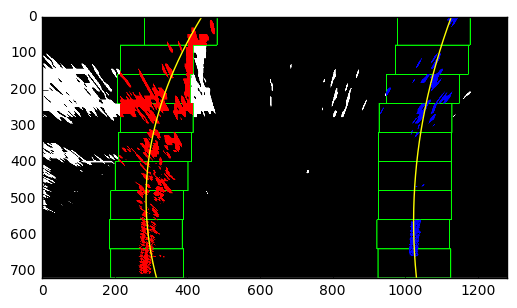

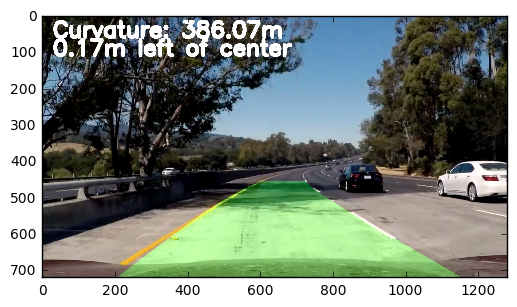

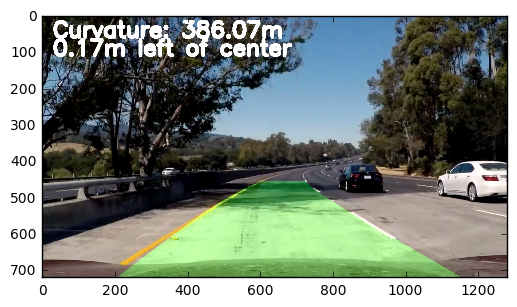

In [ ]:
test_images = glob.glob('test_images/*.jpg')
for image in test_images:
    left_line = Line()
    right_line = Line()
    plt.imshow(pipeline(mpimg.imread(image), plot=True))
    plt.show()

In [30]:
from moviepy.editor import VideoFileClip
left_line = Line()
right_line = Line()
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:18<00:00,  6.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 47s, sys: 2.73 s, total: 4min 49s
Wall time: 3min 19s


In [258]:
np.mean(np.asarray(left_line.recent_xfitted), axis=0).shape

(720,)

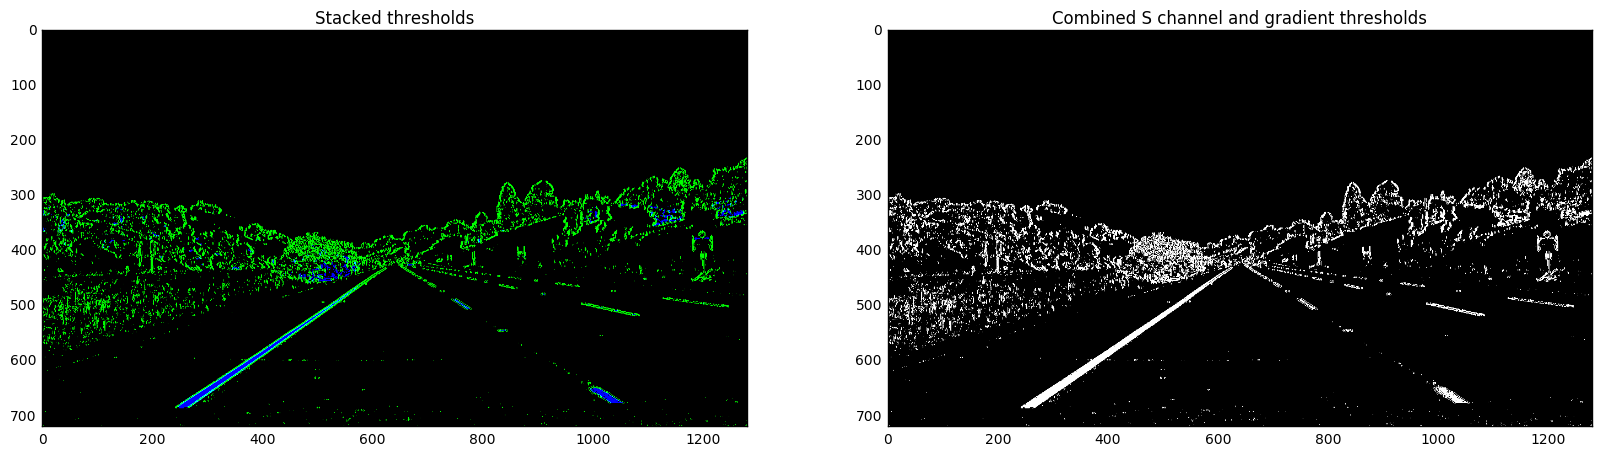

In [31]:
img = mpimg.imread('test_images/straight_lines1.jpg')
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary * 255)
ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')
plt.show()

In [211]:
from collections import deque
tazo = deque(maxlen=5)

In [215]:
tazo.append(7)

In [217]:
np.asarray(tazo)

array([5, 6, 7])